In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Functional, Model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from keras.applications import imagenet_utils
import cv2
from PIL import Image
import warnings
from keras.preprocessing import image
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
def crop_img(path_to_image):
    img = cv2.imread(path_to_image)
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img = cv2.resize(img, (512, 512))
    img = img[43:362, 60:480]
    img = cv2.resize(img, (512, 512))
    out = []
    for i in range(8):
        temp = []
        for j in range(8):
            temp.append(img[i*64:(i+1)*64,j*64:(j+1)*64])
        out.append(temp)
    return out

In [ ]:
imgs = crop_img('1.png')

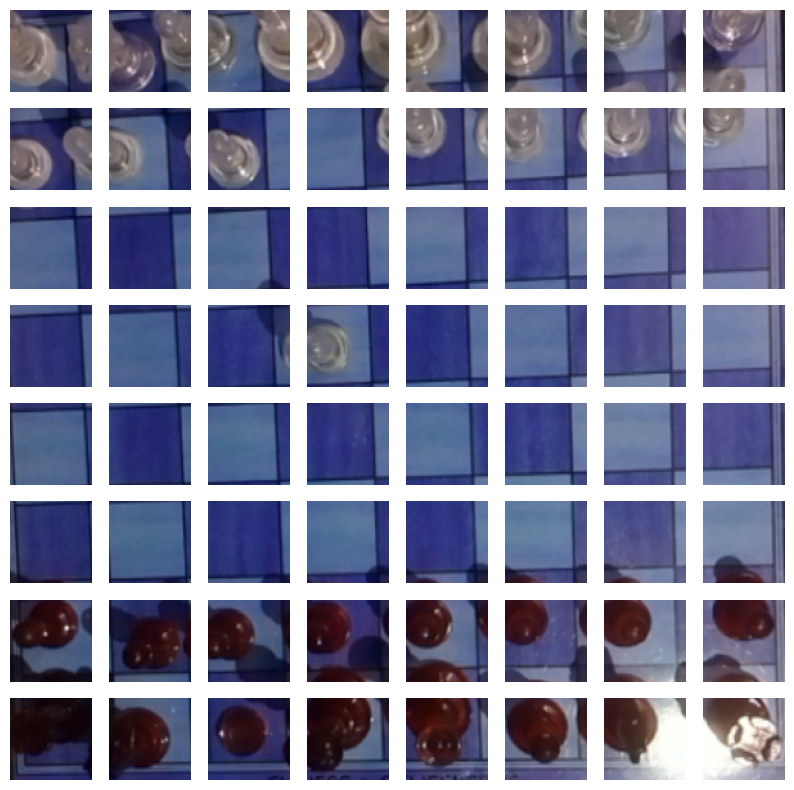

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(10, 10))
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(imgs[i][j])
        axs[i,j].axis('off')
plt.show()

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  1


In [ ]:
e = 0
w = 1
b = 2
actual = ['empty', 'white', 'black']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_labels = [
	[
	[b, e, e, b, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, b, e],
	[e, e, w, e, e, e, e, e],
	[e, e, e, b, e, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, w, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, w, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, b, e],
	[e, e, e, e, e, e, e, e],
	[e, e, e, e, e, e, w, e],
	[w, e, b, e, e, b, e, e],
	[e, w, e, e, w, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, w, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, e, b],
	[e, e, e, e, e, e, e, e],
	[e, e, w, b, e, e, w, b],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, e, e, w],
	[e, e, w, e, e, e, e, e]
	],
	[
	[b, e, e, e, e, w, e, b],
	[e, e, e, e, e, e, e, e],
	[b, w, e, b, e, e, e, b],
	[e, e, e, e, e, e, w, e],
	[e, e, e, b, e, e, w, b],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, w, e, e, e],
	[e, e, e, e, e, e, e, e]
	],
	[
	[e, e, b, e, e, w, e, e],
	[e, e, e, e, e, e, e, e],
	[b, b, e, b, e, e, e, b],
	[e, e, e, e, e, e, w, e],
	[e, w, e, e, w, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[e, e, e, e, b, e, e, e]
	],
	[
	[w, e, b, e, e, w, e, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, w, e, b],
	[e, b, e, e, e, e, w, e],
	[e, e, e, b, e, e, w, e],
	[w, e, e, e, e, e, e, e],
	[e, w, e, e, e, b, e, e],
	[e, e, e, e, b, e, e, w]
	]
]

val_labels = [
	[
	[e, e, w, e, e, e, w, e],
	[e, e, b, e, e, e, e, w],
	[b, e, e, b, e, b, e, e],
	[e, e, e, e, e, e, w, e],
	[e, e, e, b, e, b, e, e],
	[w, e, e, w, e, e, e, e],
	[e, e, e, e, e, b, e, e],
	[w, e, b, e, e, e, e, w]
	],
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, w],
	[b, e, e, b, e, b, e, e],
	[e, e, b, e, e, e, w, e],
	[e, e, e, b, e, e, e, e],
	[w, e, e, w, e, e, e, e],
	[e, e, e, e, e ,b, e, e],
	[e, e, b, e, e, e, e, w]
	]
]

test_labels = [
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, b, e, e],
	[e, e, b, e, b, e, e, e],
	[e, b, e, b, e, e, e, e],
	[w, e, e, w, e, e, e, w],
	[e, e, e, e, e, e, e, e],
	[e, e, e, w, e, e, e, w]
	],
	[
	[w, e, w, e, b, e, w, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, b, e, e, e, w],
	[e, e, e, e, b, e, e, e],
	[e, e, e, b, e, e, e, e],
	[w, e, e, w, e, e, b, e],
	[e, e, e, e, e, e, e, e],
	[b, e, e, w, e, b, e, w]
	]
]

In [ ]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(len(train_labels)):
    imgs = crop_img(f'../../data/chessBot/{i+1}.png')
    for j in range(8):
        for k in range(8):
            l = train_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/train/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/train/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/train/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [ ]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(2):
    imgs = crop_img(f'../../data/chessBot/{11+i}.png')
    for j in range(8):
        for k in range(8):
            l = val_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/val/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/val/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/val/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [ ]:
empty_count = 0
white_count = 0
black_count = 0
for i in range(2):
    imgs = crop_img(f'../../data/chessBot/{13+i}.png')
    for j in range(8):
        for k in range(8):
            l = test_labels[i][j][k]
            if l == e:
                cv2.imwrite(f'../../data/chessBot/test/empty/{empty_count}.png', imgs[j][k])
                empty_count += 1
            elif l == w:
                cv2.imwrite(f'../../data/chessBot/test/white/{white_count}.png', imgs[j][k])
                white_count += 1
            elif l == b:
                cv2.imwrite(f'../../data/chessBot/test/black/{black_count}.png', imgs[j][k])
                black_count += 1

In [ ]:
train_path='/content/drive/MyDrive/ML_Data/chessBot/train/'
valid_path='/content/drive/MyDrive/ML_Data/chessBot/val/'
test_path='/content/drive/MyDrive/ML_Data/chessBot/test/'

In [ ]:
def preprocess_image(image_path):
    # Load the image using PIL
    input_shape = (224, 224)
    img = Image.open(image_path)
    img_array = np.array(img)

    # Normalize pixel values
    img_array = img_array.astype(np.float32) / 127.5 - 1

    # Reorder dimensions from (H, W, C) to (C, H, W)
    img_array = np.transpose(img_array, (2, 0, 1))

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 384 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Found 128 images belonging to 3 classes.


In [ ]:
# names of classes
train_batches.class_indices

{'black': 0, 'empty': 1, 'white': 2}

In [ ]:
imgs, labels = next(train_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

AttributeError: ignored

In [ ]:
mobile=keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
x = mobile.layers[-6].output
x = tf.keras.layers.Reshape(target_shape = (7*7*1024, ))(x)
output = Dense(units=3, activation='softmax')(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs = 15, verbose = 2)

Epoch 1/15
39/39 - 83s - loss: 0.5390 - accuracy: 0.9089 - val_loss: 0.0927 - val_accuracy: 0.9453 - 83s/epoch - 2s/step
Epoch 2/15
39/39 - 2s - loss: 0.0201 - accuracy: 0.9922 - val_loss: 0.0173 - val_accuracy: 0.9922 - 2s/epoch - 47ms/step
Epoch 3/15
39/39 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9922 - 2s/epoch - 46ms/step
Epoch 4/15
39/39 - 2s - loss: 3.1751e-04 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000 - 2s/epoch - 51ms/step
Epoch 5/15
39/39 - 2s - loss: 5.7872e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000 - 2s/epoch - 57ms/step
Epoch 6/15
39/39 - 2s - loss: 9.4439e-04 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000 - 2s/epoch - 46ms/step
Epoch 7/15
39/39 - 2s - loss: 2.2078e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000 - 2s/epoch - 45ms/step
Epoch 8/15
39/39 - 2s - loss: 4.7978e-05 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000 - 2s/epoch - 45ms/step
Epoch 9/15
3

In [ ]:
# model.input_shape

(None, 224, 224, 3)

In [ ]:
# train_batches[0][0].shape

(8, 224, 224, 3)

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

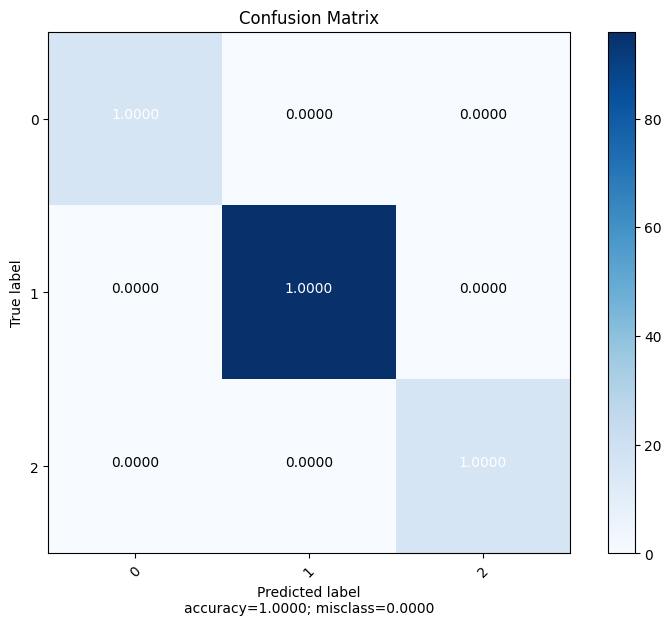

In [ ]:
cm_plot_labels = ['0', '1', '2']
plot_confusion_matrix(cm=cm, target_names=cm_plot_labels, title='Confusion Matrix')

In [ ]:
predictions.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
model.save('mymodel')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/mymodel') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('saved_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:
!zip -r /content/original_model.zip /content/mymodel

  adding: content/mymodel/ (stored 0%)
  adding: content/mymodel/variables/ (stored 0%)
  adding: content/mymodel/variables/variables.index (deflated 77%)
  adding: content/mymodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/mymodel/assets/ (stored 0%)
  adding: content/mymodel/saved_model.pb (deflated 91%)
  adding: content/mymodel/keras_metadata.pb (deflated 95%)
  adding: content/mymodel/fingerprint.pb (stored 0%)
